<a href="https://colab.research.google.com/github/Nahom32/CV-Lab-Experiments/blob/main/notebooks/Chapter11.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
!pip install ultralytics

In [11]:
!pip install onnx

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 38.7 MB/s eta 0:00:00


In [18]:
!pip install onnxruntime

In [2]:

from ultralytics import YOLO
import cv2

model = YOLO('yolov8n.pt')  # Or yolov8s.pt for higher accuracy
cap = cv2.VideoCapture(0)

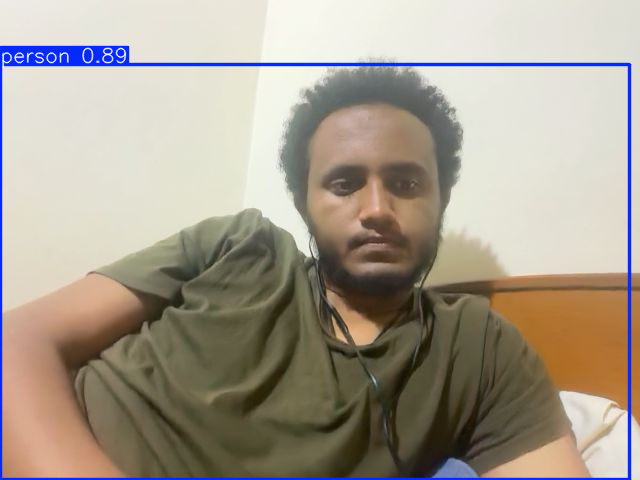

In [8]:
from IPython.display import display, HTML
from google.colab.output import eval_js
import cv2
from base64 import b64decode
from ultralytics import YOLO

# JavaScript code to capture an image from the webcam
js_code = '''
async function takePhoto(quality) {
  const div = document.createElement('div');
  const capture = document.createElement('button');
  capture.textContent = 'Capture';
  div.appendChild(capture);

  const video = document.createElement('video');
  video.style.display = 'block';
  const stream = await navigator.mediaDevices.getUserMedia({video: true});

  document.body.appendChild(div);
  div.appendChild(video);
  video.srcObject = stream;
  await video.play();

  google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

  await new Promise((resolve) => capture.onclick = resolve);

  const canvas = document.createElement('canvas');
  canvas.width = video.videoWidth;
  canvas.height = video.videoHeight;
  canvas.getContext('2d').drawImage(video, 0, 0);
  stream.getVideoTracks()[0].stop();
  div.remove();

  return canvas.toDataURL('image/jpeg', quality);
}
'''

# Execute the JavaScript function and get the image data
display(HTML('<script>' + js_code + '</script>'))
data = eval_js('takePhoto(0.8)')

# Decode the base64 image data
binary = b64decode(data.split(',')[1])
filename = 'photo.jpg'
with open(filename, 'wb') as f:
    f.write(binary)

# Load YOLO model and perform detection
model = YOLO("yolov8n.pt")
img = cv2.imread(filename)
results = model.predict(source=img, conf=0.5, verbose=False)

# Display the result
annotated = results[0].plot()
cv2_imshow(annotated)

In [12]:
import onnx
from ultralytics import YOLO

# Load the YOLO model
model = YOLO("yolov8n.pt")

# Export to ONNX with specific parameters
model.export(format="onnx", opset=12, simplify=True)  # Try different opset values

# Verify the ONNX model
onnx_model = onnx.load('yolov8n.onnx')
onnx.checker.check_model(onnx_model)
print("ONNX model is valid!")

Ultralytics 8.3.196 🚀 Python-3.12.11 torch-2.8.0+cu126 CPU (Intel Xeon CPU @ 2.20GHz)
💡 ProTip: Export to OpenVINO format for best performance on Intel hardware. Learn more at https://docs.ultralytics.com/integrations/openvino/
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs

PyTorch: starting from 'yolov8n.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 84, 8400) (6.2 MB)
requirements: Ultralytics requirements ['onnxslim>=0.1.67', 'onnxruntime'] not found, attempting AutoUpdate...

requirements: AutoUpdate success ✅ 1.4s
WARNING ⚠️ requirements: Restart runtime or rerun command for updates to take effect


ONNX: starting export with onnx 1.19.0 opset 12...
ONNX: slimming with onnxslim 0.1.67...
ONNX: export success ✅ 3.0s, saved as 'yolov8n.onnx' (12.2 MB)

Export complete (3.8s)
Results saved to /content
Predict:         yolo predict task=detect model=yolov8n.onnx imgsz=640  
Validate:        yolo val task=detect model=yolov8n.onnx

In [16]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [19]:
import onnxruntime as ort
import numpy as np

#net = cv2.dnn.readNetFromONNX('yolov8n.onnx')
session = ort.InferenceSession("yolov8n.onnx")

# Load image
frame = cv2.imread("/content/drive/MyDrive/smiling_face.jpeg")
if frame is None:
    raise ValueError("Image not loaded! Check the path.")

# Preprocess
img = cv2.resize(frame, (640, 640))
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = img.astype(np.float32) / 255.0
img = np.transpose(img, (2, 0, 1))  # HWC -> CHW
img = np.expand_dims(img, axis=0)    # Add batch dim

# Run inference
input_name = session.get_inputs()[0].name
outputs = session.run(None, {input_name: img})

print("Inference done!")
print(outputs[0].shape)  # raw YOLOv8 output

Inference done!
(1, 84, 8400)
